In [1]:
import pandas as pd
import numpy as np
import sys #Libreria para gestionar directorios 
import os  #
import time #libreria para el tiempo
import itertools #
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator #Keras preprocesa las imagenes para entrenar al algoritmos
from tensorflow.python.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam,Nadam
from tensorflow.python.keras import optimizers #Optimixador para entrenar
from tensorflow.python.keras.models import Sequential #Libreria que permite hacer redes neuronales secuenciales es decir que esta en orden
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation #
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D #Permiten crear las  capas que se utilizan para las convoluciones y pooling
from tensorflow.python.keras import backend as K #Mata procesos dentro de la secion para iniciar uno nuevo
from keras.preprocessing import image
from mlxtend.evaluate import confusion_matrix
import matplotlib.image as mpimg
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Crea una nueva secion limpia en keras para un nuevo entrenamiento
K.clear_session()

#Ruta de directorios una para entrenar con las imagenes de los 52 generos de peces y otra para validar los datos
data_entrenamiento = './data/entrenamiento'
data_validacion = './data/validacion'
#data_pruebas='./data/pruebas/'

In [3]:
#Hyperparameters
epocas=100 # Cantidad de iteraciones para el algotimo de entrenamiento
longitud, altura = 150, 150 #Longitud y altura de la convolucion utilizado para el entrenamiento
batch_size = 32 #Numero de imagenes que procesa la pc en cada paso
#pasos = 1000 
#validation_steps = 300
filtrosConv1 = 32 #Numero de filtros que se aplica en la primera convolucion
filtrosConv2 = 64 #Numero de filtros que se aplica tras la segunda convolucion
filtrosConv3 = 128 #Numero de filtros que se aplica tras la segunda convolucion
filtrosConv4 = 256 #Numero de filtros que se aplica tras la segunda convolucion
tamano_filtro1 = (3, 3) #Para primera conv
tamano_filtro2 = (2, 2) #Para segunda conv
tamano_filtro3 = (3, 3) #Para tercera conv
tamano_filtro4 = (3, 3) #Para cuarta conv
tamano_pool = (2, 2) #Mejora el proceso de convolucion
clases = 52           #Numeros tipos de animales
lr = 0.0003 # #Tasa de aprendizaje, este es el lering ray es que tan grande van hacer los ajustes en la red para acercarse a una solucion optima

In [4]:
##Preparamos nuestras imagenes Preporcesamiento
#Transformacion
#Linea 3 
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255, #Es el rango de pixeles y se convierten de cero a uno para optimzar el entrenamineto y sea rapido
    shear_range=0.3, #Genera las imagnes para aque aprenda en diferente posiciones las inclinas
    zoom_range=0.3, #zoom o partes de una imagen 
    horizontal_flip=True) #Direccionalidad en la imagen invierte la imagen

validacion_datagen = ImageDataGenerator(rescale=1. /255)

#Preparacion de imagenes para el entrenamiento

#Entra al direcrio de entrenaminento y las proceso en funcion a los parametros definidos anteriormente, y clase categorica por los tres animales
imagen_entrenamiento = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

#Entra al direcctorio de validacion y prepara las imagenes de validacion
imagen_validacion = validacion_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')


print(imagen_entrenamiento.class_indices)

Found 572 images belonging to 52 classes.
Found 520 images belonging to 52 classes.
{'Agonostomus': 0, 'Ancistrus': 1, 'Andinoacara': 2, 'Apteronotus': 3, 'Astroblepus': 4, 'Astyanax': 5, 'Awaous': 6, 'Batrochoglanis': 7, 'Brachyhypopomus': 8, 'Brycon': 9, 'Bryconamericus': 10, 'Chaetostoma': 11, 'Cichlasoma': 12, 'Cordylancistrus': 13, 'Dormitator': 14, 'Eleotris': 15, 'Gasteropelecus': 16, 'Gobioides': 17, 'Gobiomorus': 18, 'Grundulus': 19, 'Gymnotus': 20, 'Hemiancistrus': 21, 'Hemieleotris': 22, 'Hoplias': 23, 'Hyphessobrycon': 24, 'Ichthyoelephas': 25, 'Iotabrycon': 26, 'Isorineloricaria': 27, 'Ituglanis': 28, 'Landonia': 29, 'Lebiasina': 30, 'Leporinus': 31, 'Microglanis': 32, 'Paracetopsis': 33, 'Phenacobrycon': 34, 'Pimelodella': 35, 'Pomadasys': 36, 'Pseudochalceus': 37, 'Pseudocurimata': 38, 'Pseudophallus': 39, 'Pseudopoecilia': 40, 'Rhamdia': 41, 'Rhoadsia': 42, 'Rineloricaria': 43, 'Roeboides': 44, 'Saccodon': 45, 'Sicydium': 46, 'Sternopygus': 47, 'Strongylura': 48, 'Sturi

In [5]:
#Hyperparametros que sirven para el entrenamiento por cantidad
pasos_entrenamiento= imagen_entrenamiento.n//imagen_entrenamiento.batch_size
pasos_validacion= imagen_validacion.n//imagen_validacion.batch_size

In [6]:
#Creacion de red convolucional
cnn = Sequential() #Modelo de secuencia para trabajar con la red de manera secuencial
#Proceso de convolucion
#Anadimos la capa de convolucion, Agrega filtros, el tamano del filtro, 
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape=(longitud, altura, 3), activation='tanh'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding ="same", activation='tanh'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv3, tamano_filtro3, padding ="same", activation='tanh'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv4, tamano_filtro4, padding ="same", activation='tanh'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

#Flattening
cnn.add(Flatten()) #Proceso de conversion de la imagen a un vector plano en una dimension
#Capa que conecta con la anterior y la sgte con 256 conexiones
cnn.add(Dense(256, activation='relu')) #Agrega una capa con el fitlro relu
#Dropout
cnn.add(Dropout(0.2))# Apaga el 50 % de las reurona a cada paso para evitar la saturacion
#Ultima capa que aplica sofmax o la funcion de activacion que determina la clase en funcino a la mayor probabilidad
cnn.add(Dense(clases, activation='sigmoid'))

In [7]:
# Calculo de tiempo 
starttime = time.time()
print("Tiempo iniciado")

#Algoritmo de perida, optimizador, metricas para observar la eficiencia
cnn.compile(loss='mean_squared_error',
            optimizer=optimizers.Nadam(lr=lr),
            metrics=['accuracy'])

H= cnn.fit_generator(
    imagen_entrenamiento,#Datos preparados
    steps_per_epoch=pasos_entrenamiento,
    epochs= epocas,
    validation_data=imagen_validacion,
    validation_steps=pasos_validacion)


endtime = time.time()

ttime = endtime - starttime
print("Tiempo transcurrido para el entrenamiento====> ",ttime )



Tiempo iniciado
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 31.7647 - loss: 0.0608 - acc: 0.0167WARNING:tensorflow:From c:\users\tony_\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


c:\users\tony_\appdata\local\programs\python\python37\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


17/17 [==============================] - 41s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0608 - acc: 0.0167 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 2/100
17/17 [==============================] - 35s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0224 - acc: 0.0148 - val_loss: 0.0192 - val_acc: 0.0273
Epoch 3/100
17/17 [==============================] - 34s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0208 - acc: 0.0185 - val_loss: 0.0192 - val_acc: 0.0215
Epoch 4/100
17/17 [==============================] - 38s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0200 - acc: 0.0352 - val_loss: 0.0192 - val_acc: 0.0176
Epoch 5/100
17/17 [==============================] - 38s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0198 - acc: 0.0222 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 6/100
17/17 [==============================] - 43s 3s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0200 - acc: 0.0185 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 7/100
17/17 [===============

17/17 [==============================] - 35s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0192 - acc: 0.0204 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 52/100
17/17 [==============================] - 45s 3s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0193 - acc: 0.0148 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 53/100
17/17 [==============================] - 46s 3s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0192 - acc: 0.0148 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 54/100
17/17 [==============================] - 39s 2s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0192 - acc: 0.0167 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 55/100
17/17 [==============================] - 43s 3s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0193 - acc: 0.0185 - val_loss: 0.0192 - val_acc: 0.0332
Epoch 56/100
17/17 [==============================] - 52s 3s/step - batch: 8.0000 - size: 31.7647 - loss: 0.0192 - acc: 0.0278 - val_loss: 0.0192 - val_acc: 0.0195
Epoch 57/100
17/17 [=========

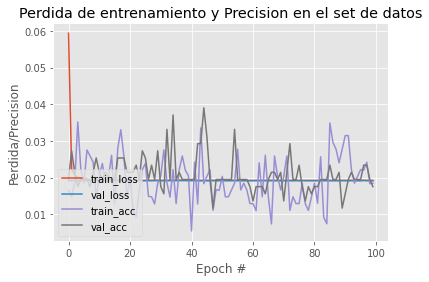

In [8]:
N=epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_acc"], label="val_acc")
plt.title("Perdida de entrenamiento y Precision en el set de datos")
plt.xlabel("Epoch #")
plt.ylabel("Perdida/Precision")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [9]:
#Pruebas
test_datagen= ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    directory="./data/pruebas/",
    target_size=(altura, longitud),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42)

Found 49 images belonging to 1 classes.


In [10]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_generator.reset()
pred=cnn.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [11]:
predicted_class_indices= np.argmax(pred,axis=1)

In [12]:
#Resultados de la prediccion bien o mal
print(predicted_class_indices)
print(type(predicted_class_indices))

[ 4  4  4 42  3  4 43 43 42 23  4 37 32  4  4 43 42  4  4  4 42  4  4 43
 43  4  4  4  4 43 42  4  4  4  4 42  4 43 43 43 43 43  4 43  4  4 43  4
 42]
<class 'numpy.ndarray'>


In [13]:
labels = (imagen_entrenamiento.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [14]:
#Genera un exel con la imagen y su prediccion
#Esto con el fun de comparar cuantos ha asetardo
filenames= test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results1.csv", index=False)

In [15]:
real_class_indices=[]
print(len(filenames))
for i in range(0, len(filenames)):
    your_path = filenames[i]
    path_list = your_path.split(os.sep)
    if ("Agonostomus" in path_list[1]):
        real_class_indices.append(0)
    if ("Ancistrus" in path_list[1]):
        real_class_indices.append(1)
    if ("Andinoacara" in path_list[1]):
        real_class_indices.append(2)
    if ("Apteronotus" in path_list[1]):
        real_class_indices.append(3)
    if ("Astroblepus" in path_list[1]):
        real_class_indices.append(4)
    if ("Astyanax" in path_list[1]):
        real_class_indices.append(5)
    if ("Awaous" in path_list[1]):
        real_class_indices.append(6)
    if ("Batrochoglanis" in path_list[1]):
        real_class_indices.append(7)
    if ("Brachyhypopomus" in path_list[1]):
        real_class_indices.append(8)
    if ("Brycon" in path_list[1]):
        real_class_indices.append(9)
    if ("Bryconamericus" in path_list[1]):
        real_class_indices.append(10)
    if ("Chaetostoma" in path_list[1]):
        real_class_indices.append(11)
    if ("Cichlasoma" in path_list[1]):
        real_class_indices.append(12)
    if ("Cordylancistrus" in path_list[1]):
        real_class_indices.append(13)
    if ("Dormitator" in path_list[1]):
        real_class_indices.append(14)
    if ("Eleotris" in path_list[1]):
        real_class_indices.append(15)
    if ("Gasteropelecus" in path_list[1]):
        real_class_indices.append(16)
    if ("Gobioides" in path_list[1]):
        real_class_indices.append(17)
    if ("Gobiomorus" in path_list[1]):
        real_class_indices.append(18)
    if ("Grundulus" in path_list[1]):
        real_class_indices.append(19)
    if ("Gymnotus" in path_list[1]):
        real_class_indices.append(20)
    if ("Hemiancistrus" in path_list[1]):
        real_class_indices.append(21)
    if ("Hemieleotris" in path_list[1]):
        real_class_indices.append(22)
    if ("Hoplias" in path_list[1]):
        real_class_indices.append(23)
    if ("Hyphessobrycon" in path_list[1]):
        real_class_indices.append(24)
    if ("Ichthyoelephas" in path_list[1]):
        real_class_indices.append(25)
    if ("Iotabrycon" in path_list[1]):
        real_class_indices.append(26)
    if ("Isorineloricaria" in path_list[1]):
        real_class_indices.append(27)
    if ("Ituglanis" in path_list[1]):
        real_class_indices.append(28)
    if ("Landonia" in path_list[1]):
        real_class_indices.append(29)
    if ("Lebiasina" in path_list[1]):
        real_class_indices.append(30)
    if ("Leporinus" in path_list[1]):
        real_class_indices.append(31)
    if ("Microglanis" in path_list[1]):
        real_class_indices.append(32)
    if ("Paracetopsis" in path_list[1]):
        real_class_indices.append(33)
    if ("Phenacobrycon" in path_list[1]):
        real_class_indices.append(34)
    if ("Pimelodella" in path_list[1]):
        real_class_indices.append(35)
    if ("Pomadasys" in path_list[1]):
        real_class_indices.append(36)
    if ("Pseudochalceus" in path_list[1]):
        real_class_indices.append(37)
    if ("Pseudocurimata" in path_list[1]):
        real_class_indices.append(38)
    if ("Pseudophallus" in path_list[1]):
        real_class_indices.append(39)
    if ("Pseudopoecilia" in path_list[1]):
        real_class_indices.append(40)
    if ("Rhamdia" in path_list[1]):
        real_class_indices.append(41)
    if ("Rhoadsia" in path_list[1]):
        real_class_indices.append(42)
    if ("Rineloricaria" in path_list[1]):
        real_class_indices.append(43)
    if ("Roeboides" in path_list[1]):
        real_class_indices.append(44)
    if ("Saccodon" in path_list[1]):
        real_class_indices.append(45)
    if ("Sicydium" in path_list[1]):
        real_class_indices.append(46)
    if ("Sternopygus" in path_list[1]):
        real_class_indices.append(47)
    if ("Strongylura" in path_list[1]):
        real_class_indices.append(48)
    if ("Sturisoma" in path_list[1]):
        real_class_indices.append(49)
    if ("Synbranchus" in path_list[1]):
        real_class_indices.append(50)
    if ("Trichomycterus" in path_list[1]):
        real_class_indices.append(51)

print(real_class_indices)
print(len(real_class_indices))
real_class_indices = np.array(real_class_indices)
print(type(real_class_indices))

49
[1, 1, 1, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 10, 11, 11, 11, 23, 24, 25, 30, 30, 31, 31, 31, 35, 37, 38, 38, 38, 38, 38, 38, 42, 42, 42, 44, 44, 45, 45, 45, 51, 51]
49
<class 'numpy.ndarray'>


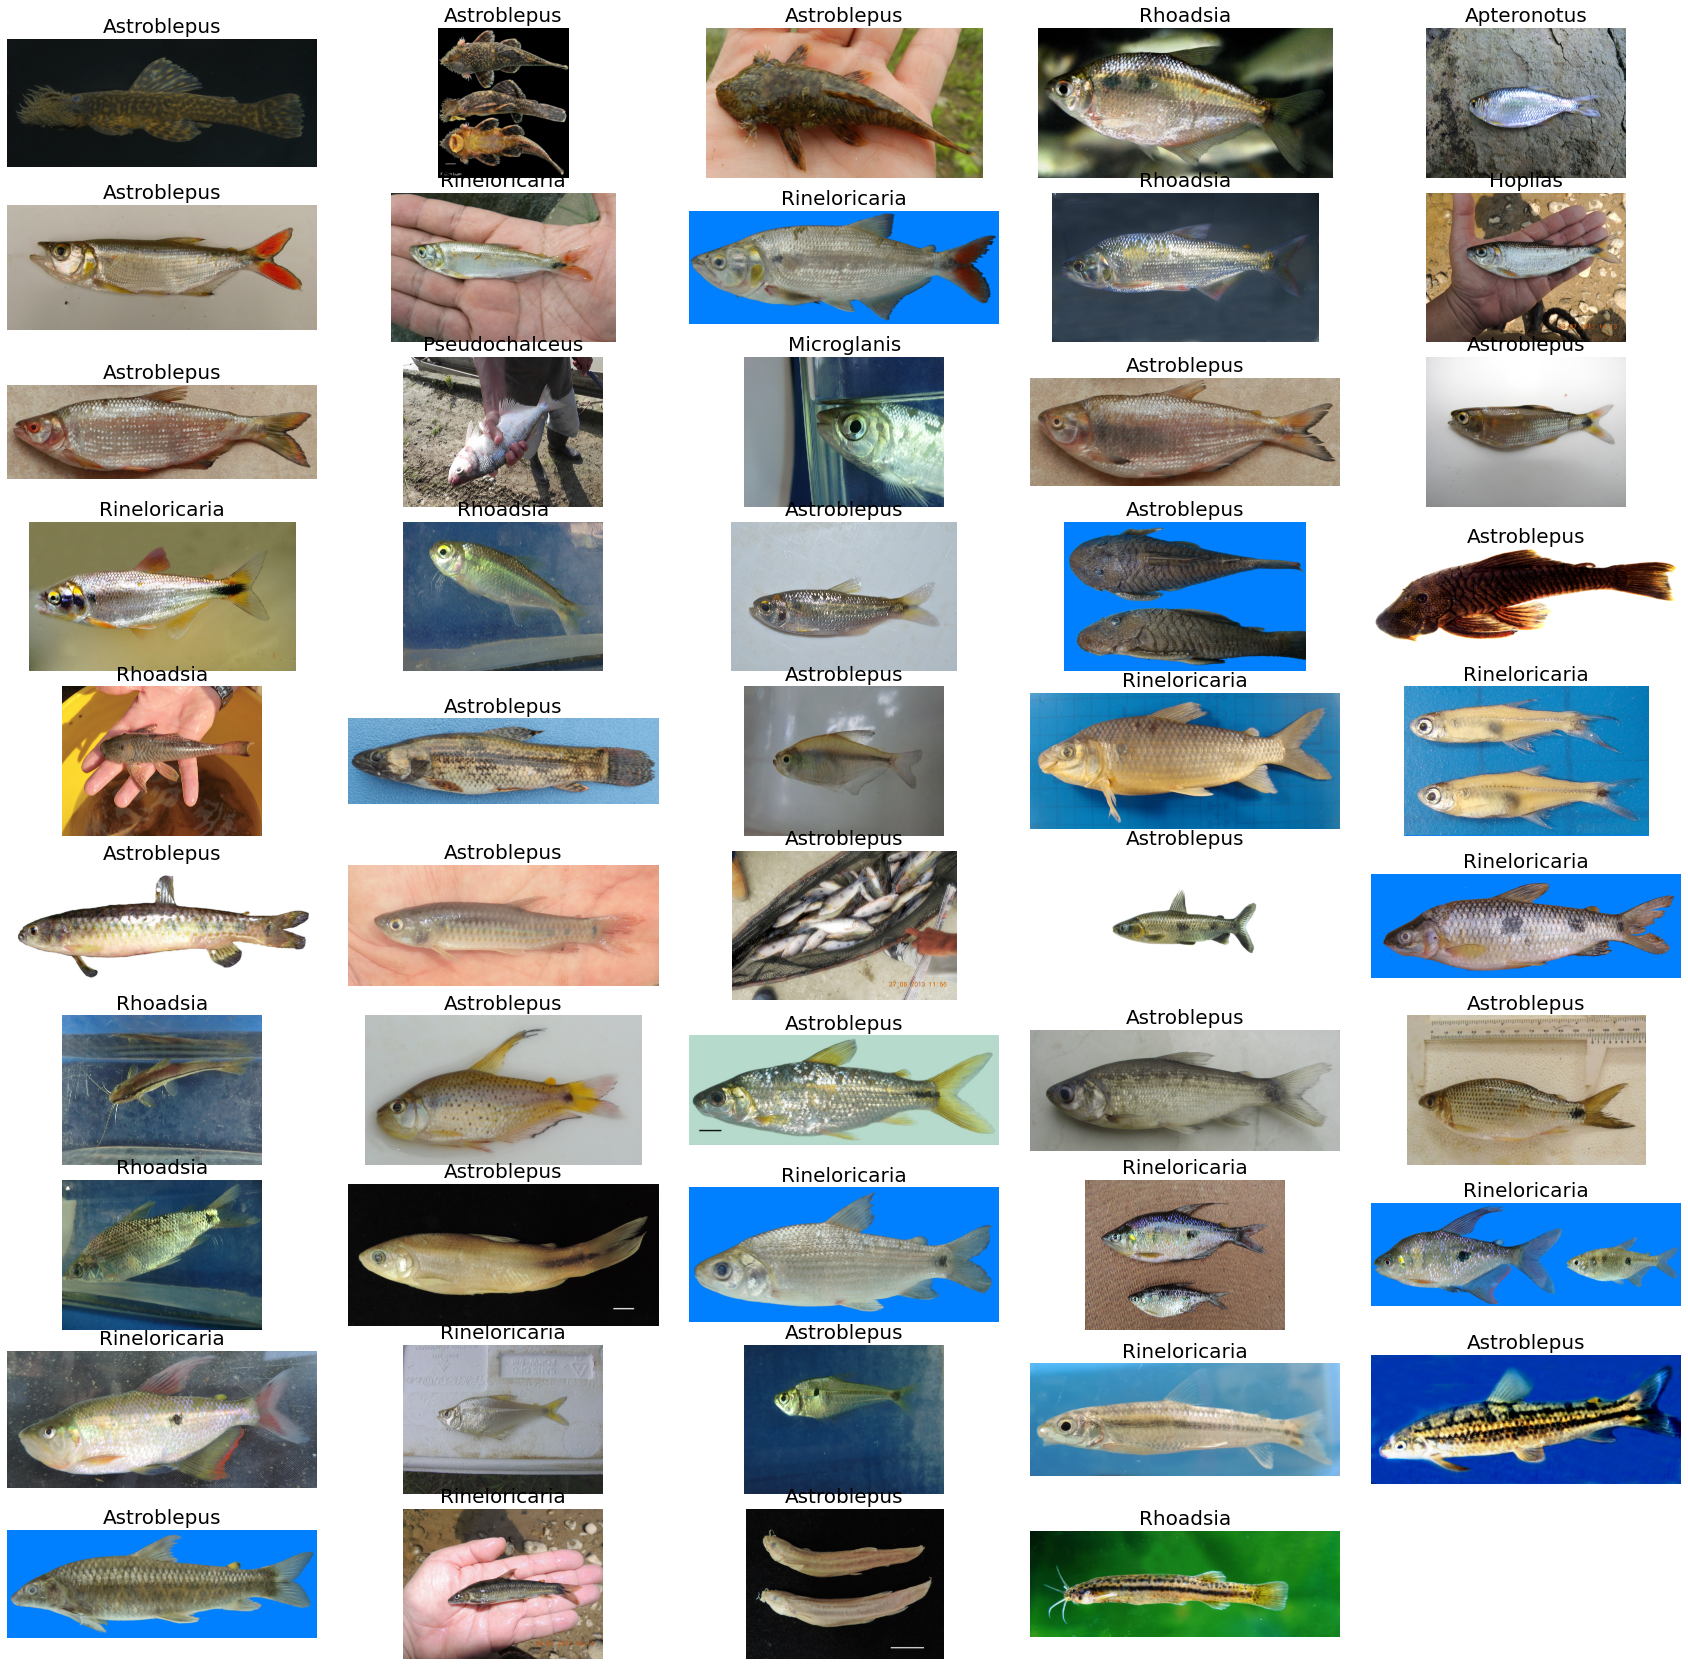

In [16]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
rows=10
cols=len(filenames)//rows if len(filenames)% 2 == 0 else len(filenames)//rows +1
folder = "data/pruebas/test_images/"
for i in range(0, len(filenames)):
    #print(filenames[i])
    your_path = filenames[i]
    path_list = your_path.split(os.sep)
    #print(path_list)
    img=mpimg.imread(folder +path_list[1])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    plt.imshow(img, interpolation=None)
    ax.set_title(predictions[i], fontsize=20)

In [17]:
cm= confusion_matrix(real_class_indices,predicted_class_indices)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """""
    Esta funcion imprime y plotea la matris de confusion
    Normalizacionpuede ser aplicada por la configuracion de 'normalize=True'
    """""
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i,j]> thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 5 0 0 0 0 1 0 0 0 0 1 0 1 0 2 3 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


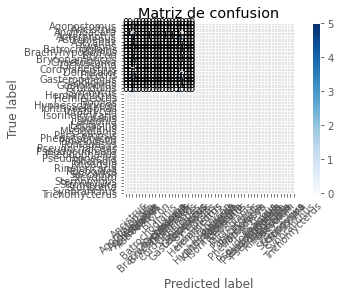

In [19]:

cm_plot_labels= imagen_entrenamiento.class_indices
plot_confusion_matrix(cm,cm_plot_labels, title='Matriz de confusion')

In [20]:
target_dir = './modelo/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
cnn.save('./modelo/modelo.h5')#Guarda la estructura del modelo
cnn.save_weights('./modelo/pesos.h5')  #Guarda los pesos de los modelos